In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [2]:
suf = '04_17_23'

with open(f'hists_cutflows_ProcessorV3_{suf}.pickle', 'rb') as file:
    data3 = pickle.load(file)
    
with open(f'hists_cutflows_ProcessorV2_{suf}.pickle', 'rb') as file:
    data2 = pickle.load(file)

In [3]:
set2 = {
    thing.split('_')[0] + '_' + thing.split('_')[1] + '_' + thing.split('_')[2] 
    for thing in data2.keys()
    if len(thing.split('_')) > 2
}

set3 = {
    thing.split('_')[0] + '_' + thing.split('_')[1] + '_' + thing.split('_')[2] 
    for thing in data3.keys()
    if len(thing.split('_')) > 2
}

# intersection = set2.intersection(set3)
intersection = {'PhiToPi0Pi0_mPhi0p3_ctau300', 'PhiToPiPlusPiMinus_mPhi0p3_ctau300'}

data = data3

In [ ]:
set3

In [ ]:
intersection

In [4]:
for sample in intersection:
    print(f"nEvents: {data2[sample]['numEvents_pretrigger']}")

print(data2['background']['numEvents_pretrigger'])

for sample in intersection:
    print(f"nEvents: {data3[sample]['numEvents_pretrigger']}")

print(data3['background']['numEvents_pretrigger'])

nEvents: 1541579
nEvents: 1529039
25667521
nEvents: 1541579
nEvents: 1529039
25667521


In [5]:
nEvents = {
    dataset:{
        cut[10:]: data[dataset][cut]
        for cut in data[dataset]
        if 'numEvents' in cut 
        and cut[-2:] != 'SF'
    }
    for dataset in data
    if dataset[-4:] not in ['vars','cuts']             
}

muon_SFs = {
            dataset[:-5]:{
                cut[12:]: data[dataset][cut]
                for cut in data[dataset]
                if 'muonSF' in cut 
            }
            for dataset in data
            if dataset[-4:] == 'vars'
        }


genfiltereff = {
    'PhiToPiPlusPiMinus_mPhi0p3_ctau1000': 0.2140541025727333, 
    'PhiToPiPlusPiMinus_mPhi0p3_ctau300': 0.2919021657580153, 
    'PhiToPi0Pi0_mPhi0p3_ctau300': 0.2913132061492869, 
    'PhiToPi0Pi0_mPhi0p3_ctau1000': 0.2133676092544987, 
    #'background': 1,
}




gllp_ctaus = {
    dataset[:-5]:{
        cut[15:]: data[dataset][cut]
        for cut in data[dataset]
        if 'gLLP_ctau' in cut 
    }
    for dataset in data
    if dataset[-4:] == 'vars'
}

gllp_limit = {
    dataset[:-5]:{}
    for dataset in data
    if dataset[-4:] == 'vars'
}

In [6]:
nEvents2 = {
    dataset:{
        cut[10:]: data2[dataset][cut]
        for cut in data2[dataset]
        if 'numEvents' in cut 
        and cut[-2:] != 'SF'
    }
    for dataset in data2
    if dataset[-4:] not in ['vars','cuts']             
}


gllp_ctaus2 = {
    dataset[:-5]:{
        cut[15:]: data2[dataset][cut]
        for cut in data2[dataset]
        if 'gLLP_ctau' in cut 
    }
    for dataset in data2
    if dataset[-4:] == 'vars'
}

gllp_limit2 = {
    dataset[:-5]:{}
    for dataset in data2
    if dataset[-4:] == 'vars'
}

In [7]:
muonfiltereff = 0.00514
xsec = 472.8e9/4e-1
lumi = 41.6

N_bb = 5e9
N_bb_p = .02

for dataset in intersection:
        num_cut = 'cls_size > 130'

        # dem_cut = 'posttrigger'
        dem_cut = 'pretrigger'

        if 'ctau1000' in dataset:
            old_ctau = 100
        if 'ctau300' in dataset:
            old_ctau = 30

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

        ctau_list = np.logspace(-.3, 4, 50)
        new_nEvents = np.zeros_like(ctau_list)

        gLLP_ctau = np.array(gllp_ctaus[dataset][num_cut])

        
        muon_SF = np.array(muon_SFs[dataset][num_cut])
        for i, new_ctau in enumerate(ctau_list):
            weight_terms = (old_ctau/new_ctau) * np.exp(gLLP_ctau*(1/old_ctau - 1/new_ctau))
            # weight_terms *= muon_SF #this applies the scale factor corrections
            weight = np.sum(weight_terms)
            new_nEvents[i] = weight

        N_sig = muonfiltereff * genfiltereff[dataset] * new_nEvents * xsec * lumi / nEvents[dataset][dem_cut]
                
        N_bkg = N_bb_p * N_bb * nEvents['background'][num_cut]/nEvents['background'][dem_cut] 
        
        BR = 2 * np.sqrt(N_bkg)/N_sig

        gllp_limit[dataset]['BR'] = BR
        gllp_limit[dataset]['ctau_list'] = ctau_list
        gllp_limit[dataset]['new_nEvents'] = new_nEvents
        gllp_limit[dataset]['N_sig'] = N_sig
        gllp_limit[dataset]['N_bkg'] = N_bkg

        #======================================

        ctau_list2 = np.logspace(-.3, 4, 50)
        new_nEvents2 = np.zeros_like(ctau_list2)

        gLLP_ctau2 = np.array(gllp_ctaus2[dataset][num_cut])
        
        for i, new_ctau in enumerate(ctau_list2):
            weight_terms = (old_ctau/new_ctau) * np.exp(gLLP_ctau2*(1/old_ctau - 1/new_ctau))
            weight = np.sum(weight_terms)
            new_nEvents2[i] = weight
                                

        N_sig2 = muonfiltereff * genfiltereff[dataset] * new_nEvents2 * xsec * lumi / nEvents2[dataset][dem_cut]
        
        N_bkg2 = N_bb_p * N_bb * nEvents2['background'][num_cut]/nEvents2['background'][dem_cut] 
        
        BR2 = 2 * np.sqrt(N_bkg2)/N_sig2

        gllp_limit2[dataset]['BR'] = BR2
        gllp_limit2[dataset]['ctau_list'] = ctau_list2
        gllp_limit2[dataset]['new_nEvents'] = new_nEvents2
        gllp_limit2[dataset]['N_sig'] = N_sig2
        gllp_limit2[dataset]['N_bkg'] = N_bkg2


In [8]:
for thing in intersection:
    print(f"Christina's {thing}: {gllp_limit2[dataset]['N_bkg']}")
    
for thing in intersection:
    print(f"Aram's {thing}: {gllp_limit[dataset]['N_bkg']}")

Christina's PhiToPi0Pi0_mPhi0p3_ctau300: 377.90949893447055
Christina's PhiToPiPlusPiMinus_mPhi0p3_ctau300: 377.90949893447055
Aram's PhiToPi0Pi0_mPhi0p3_ctau300: 377.90949893447055
Aram's PhiToPiPlusPiMinus_mPhi0p3_ctau300: 377.90949893447055


In [ ]:
378/42

In [12]:
def plotter(y_axis, ax, sets):
    # labels = {
    #     "PhiToPi0Pi0_mPhi0p3_ctau1000":        "φ→π+π-; ctau = 100cm; m = 0.3GeV",
    #     "PhiToPi0Pi0_mPhi0p3_ctau300":         f"φ→π0π0; ctau = 30cm; m = 0.3GeV",
    #     "PhiToPiPlusPiMinus_mPhi0p3_ctau300":  f"φ→π+π-; ctau = 30cm; m = 0.3GeV",
    #     "PhiToPiPlusPiMinus_mPhi0p3_ctau1000": "φ→π0π0; ctau = 30cm; m = 0.3GeV"
    # }
    
    for thing in list(sets):
        ax.plot(gllp_limit[thing]['ctau_list'], gllp_limit[thing][y_axis], label=thing)

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("ctau (cm)")
    ax.set_ylabel(f'{y_axis} limit')
    # ax.set_xlim(5e-1,1e4)
    # ax.set_ylim(1e-6,1e-1)
    ax.legend()
    ax.grid(which='both')
    ax.set_title("Aram's")
    
def plotter2(y_axis, ax, sets):
    # labels = {
    #     "PhiToPi0Pi0_mPhi0p3_ctau1000":        "φ→π+π-; ctau = 100cm; m = 0.3GeV",
    #     "PhiToPi0Pi0_mPhi0p3_ctau300":         f"φ→π0π0; ctau = 30cm; m = 0.3GeV",
    #     "PhiToPiPlusPiMinus_mPhi0p3_ctau300":  f"φ→π+π-; ctau = 30cm; m = 0.3GeV",
    #     "PhiToPiPlusPiMinus_mPhi0p3_ctau1000": "φ→π0π0; ctau = 30cm; m = 0.3GeV"
    # }
    
    for thing in list(sets):
        ax.plot(gllp_limit2[thing]['ctau_list'], gllp_limit2[thing][y_axis], label=thing)

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("ctau (cm)")
    ax.set_ylabel(f'{y_axis} limit')
    # ax.set_xlim(5e-1,1e4)
    # ax.set_ylim(1e-6,1e-1)
    ax.legend()
    ax.grid(which='both')
    ax.set_title("Christina's")

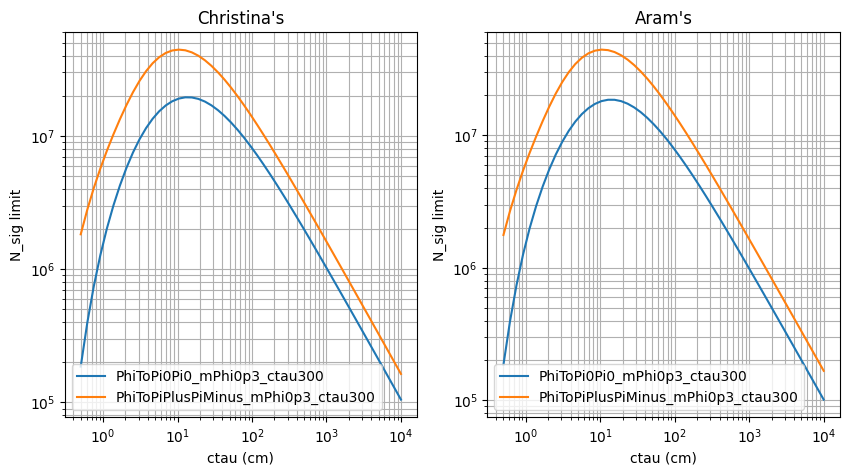

In [13]:
a = 5
fig, axes = plt.subplots(1,2, figsize = (2*a, a))
plotter('N_sig', axes[1], intersection)
plotter2('N_sig', axes[0], intersection)


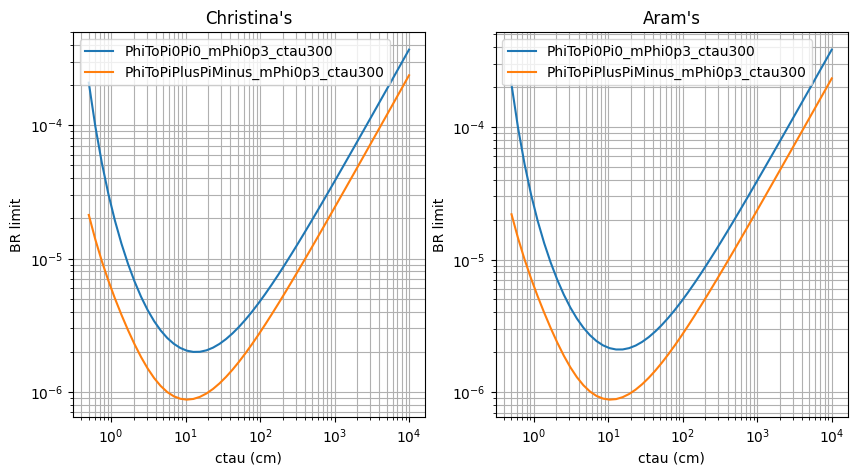

In [18]:
a = 5
fig, axes = plt.subplots(1,2, figsize = (2*a, a))
plotter('BR', axes[1], intersection)
plotter2('BR', axes[0], intersection)

In [19]:
def ratio_plotter(y_axis, ax, sets):
    # labels = {
    #     "PhiToPi0Pi0_mPhi0p3_ctau1000":        "φ→π+π-; ctau = 100cm; m = 0.3GeV",
    #     "PhiToPi0Pi0_mPhi0p3_ctau300":         f"φ→π0π0; ctau = 30cm; m = 0.3GeV",
    #     "PhiToPiPlusPiMinus_mPhi0p3_ctau300":  f"φ→π+π-; ctau = 30cm; m = 0.3GeV",
    #     "PhiToPiPlusPiMinus_mPhi0p3_ctau1000": "φ→π0π0; ctau = 30cm; m = 0.3GeV"
    # }
    
    for thing in list(sets):
        ax.plot(gllp_limit[thing]['ctau_list'], gllp_limit2[thing][y_axis]/gllp_limit[thing][y_axis], label=thing)

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("ctau (cm)")
    ax.set_ylabel(f'{y_axis} limit ratio')

    ax.legend()
    ax.grid(which='both')
    ax.set_title("Christina's/Aram's")

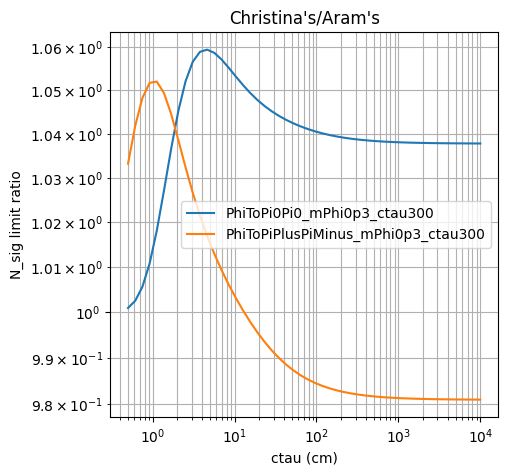

In [20]:
a = 5
fig, axes = plt.subplots(1,1, figsize = (a, a))
ratio_plotter('N_sig', axes, intersection)

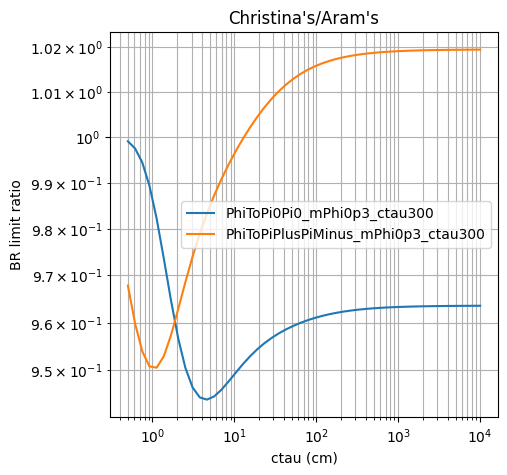

In [21]:
a = 5
fig, axes = plt.subplots(1,1, figsize = (a, a))
ratio_plotter('BR', axes, intersection)